In [1]:
from core.metrics import *
from core.semcor_bert_pipeline import load_data
from core.analysis import *
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import pandas as pd

<Figure size 432x288 with 0 Axes>

## MDS on Centroids of Shared Words

In [2]:
shared_words = ['foot', 'table', 'plane', 'degree', 'right', 'model']
db = access_db() #Some senses that were logged were not used in expt

In [3]:
def normalize_cos_dist(cs_mtx):
    max_value = np.max(1 - cs_mtx)
    return (1 - cs_mtx) / max_value

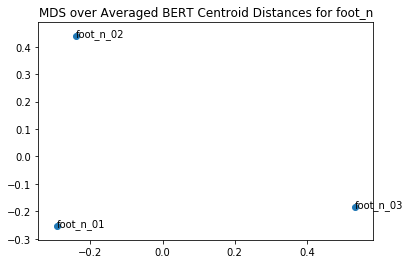

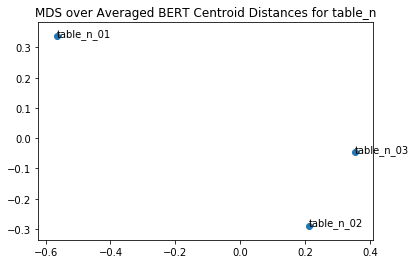

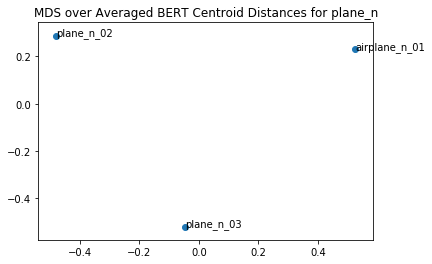

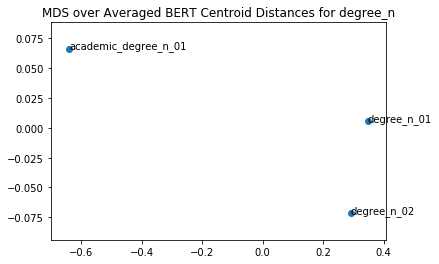

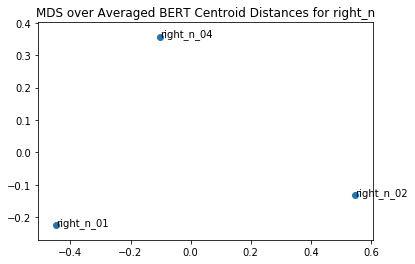

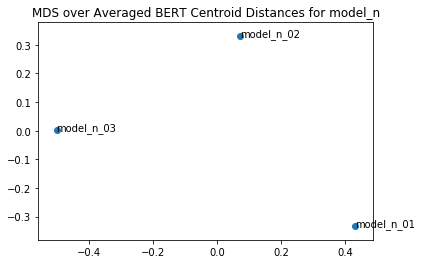

In [4]:
for w in shared_words:
    result_mtx, sense_names = cosine_sim_mtx(w, 'n',
                                             sel_senses = [fb_to_local(s) for s in get_senses(db, w + "_n")],
                                            use_masc = True)
    #result_mtx = normalize_cos_dist(result_mtx)
    result_mtx = normalize_cos_dist(result_mtx)
    mds_model = MDS(n_components = 2, dissimilarity = 'precomputed')
    plot_mds(result_mtx, w + '_n', mds_model, db, "BERT Centroid")

## Comparison with Experiment Results

In [5]:
results, incl_users = get_results_elig_users(db, "Self Consistency", 0.2)

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


Spearman Rank correlations for BERT embeddings for shared words vs. human data. Averages distances reported from experimental data reported below for comparison. 

Spearman Rank Correlations for Shared Words
foot 0.5
table 0.5
plane 0.5
degree 0.5
right 1.0
model 0.5


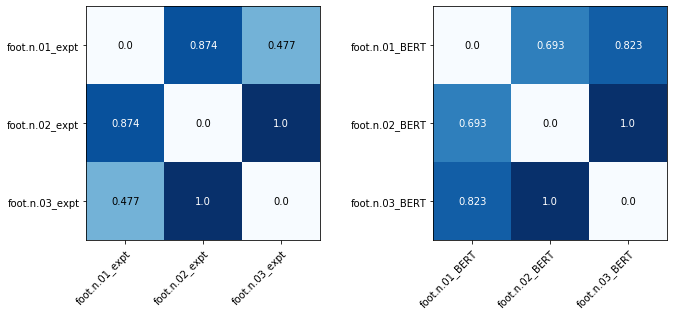

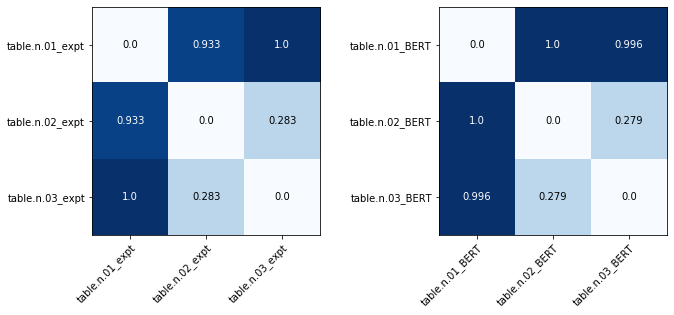

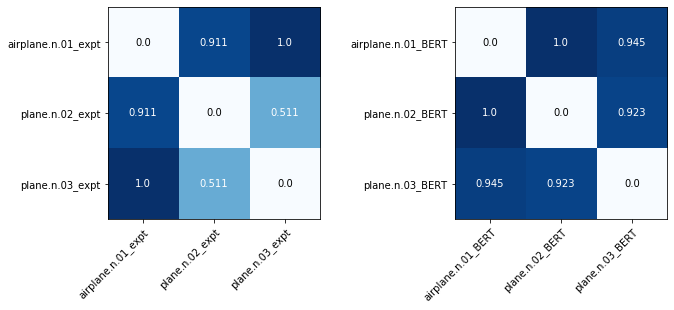

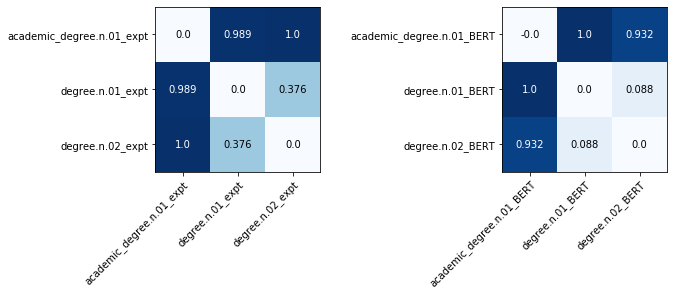

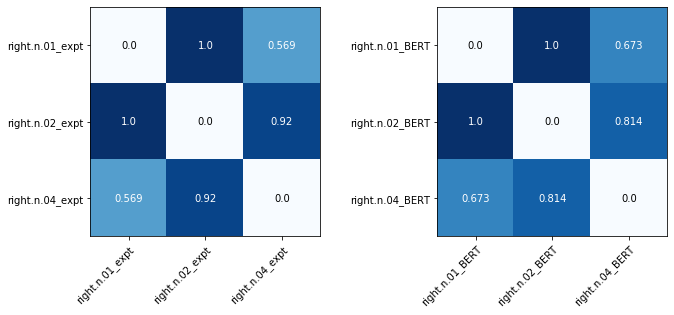

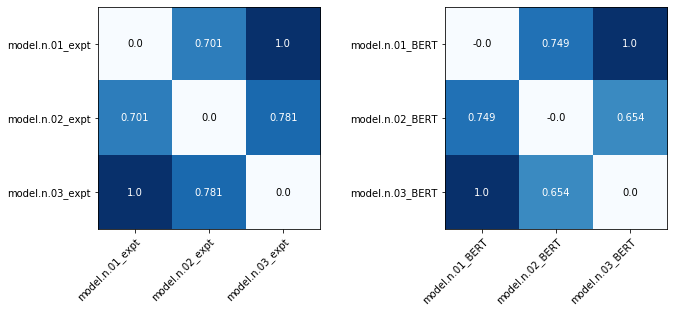

In [6]:
matrices = {w: {} for w in shared_words}

print("Spearman Rank Correlations for Shared Words")
for w in shared_words:
    expt_means = mean_distance_mtx(results, w + '_n', 'shared', incl_users)
    expt_means /= np.max(expt_means) #normalizing average reported distances
    matrices[w]['expt'] = expt_means
    bert_cs, sense_names = cosine_sim_mtx(w, 'n', sel_senses = [fb_to_local(s) for s in get_senses(db, w + "_n")],
                                          use_masc = True)
    bert_cs = normalize_cos_dist(bert_cs)
    matrices[w]['bert'] = bert_cs
    print(w, mtx_correlation([matrices[w]['bert']], [matrices[w]['expt']]))
    fig = plt.figure(figsize = (10, 10))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    im1 = ax1.imshow(expt_means)
    annotate_mtx(expt_means, im1, ax1, [s + "_expt" for s in sense_names])
    im2 = ax2.imshow(bert_cs)
    annotate_mtx(bert_cs, im2, ax2, [s + '_BERT' for s in sense_names])
    fig.tight_layout(pad = 3.0)


In [40]:
all_human_avg = [matrices[w]['expt'] for w in shared_words]
all_bert_cs = [matrices[w]['bert'] for w in shared_words]
bert_human_shared = mtx_correlation(all_human_avg, all_bert_cs, method = 'pearson')


In [38]:
import seaborn as sns

Text(0.5, 0, "Pearson's R")

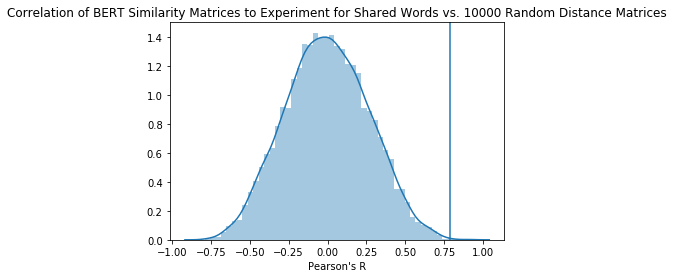

In [42]:
random_vs_human = [mtx_correlation([create_random_symmetric_mtx() for i in range(len(shared_words))],
                          all_human_avg, method = 'pearson') for i in range(10000)]
sns.distplot(random_vs_human)
plt.axvline(bert_human_shared)
plt.title("Correlation of BERT Similarity Matrices to Experiment for Shared Words vs. 10000 Random Distance Matrices")
plt.xlabel("Pearson's R")

In [46]:
def mtx_correlation(m1, m2, method = 'spearman', randomize_m1_labels = False): 
    #m1 and m2 are lists of distance matrices, spearman or pearson correlation
    assert len(m1) == len(m2)
    flat_m1 = []
    for i in range(len(m1)):
         #OpTimiZAtIoNS
        ut_m1 = m1[i][np.triu_indices(m1[i].shape[0], k = 1)]
        if randomize_m1_labels:
            np.random.shuffle(ut_m1)
        flat_m1 += ut_m1.tolist()
    flat_m2 = []
    for i in range(len(m2)):
        ut_m2 = m2[i][np.triu_indices(m2[i].shape[0], k = 1)]
        flat_m2 += ut_m2.tolist()
    if method == 'spearman':
        return stats.spearmanr(flat_m1, flat_m2)[0]
    if method == 'pearson':
        return stats.pearsonr(flat_m1, flat_m2)[0]


Text(0.5, 0, "Pearson's R")

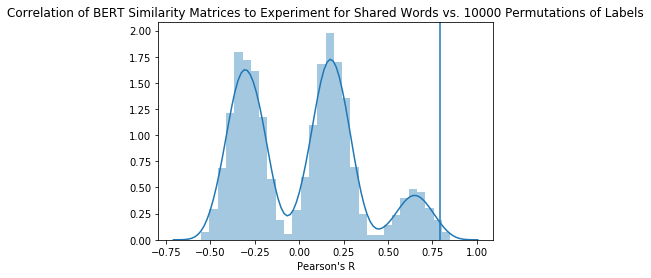

In [58]:
permuted_bert_entries = [mtx_correlation(all_bert_cs, all_human_avg,
                                         method = 'pearson', randomize_m1_labels = True) for i in range(10000)]
sns.distplot(permuted_bert_entries)
plt.axvline(bert_human_shared)
plt.title("Correlation of BERT Similarity Matrices to Experiment for Shared Words vs. 10000 Permutations of Labels")
plt.xlabel("Pearson's R")

## Full Experiment Results